In [1]:
#Initate connectiong to spark
from pyspark.sql import SparkSession

spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.74:7077") \
        .appName("Check_freq[Azad]")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores",2)\
        .config("spark.driver.port",9998)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

spark_context = spark_session.sparkContext

spark_context.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/14 15:38:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/03/14 15:38:56 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


In [2]:
#loading files 
rides = spark_session.read\
    .option("header", "true")\
    .csv('hdfs://192.168.2.74:9000/user/ubuntu/uber-tlc-foil-response/uber-trip-data/uber-raw-data-apr14.csv')\
    .cache()
#uber-trip-data has headers date/time - pickup time, Lat - lat of pickup , Alt - alt of pickup , Base - Base compnay code affiliated with pickup
rides.take(2) 

[Row(Date/Time='4/1/2014 0:11:00', Lat='40.769', Lon='-73.9549', Base='B02512'),
 Row(Date/Time='4/1/2014 0:17:00', Lat='40.7267', Lon='-74.0345', Base='B02512')]

In [3]:
rides.show(3)
rides.printSchema()

print("\nB3. number of rows in CSV file: ", rides.count())
#B.4 Count the number of partitions in the underlying RDD.
print("\nB4. number of partitions: ", rides.rdd.getNumPartitions())

+----------------+-------+--------+------+
|       Date/Time|    Lat|     Lon|  Base|
+----------------+-------+--------+------+
|4/1/2014 0:11:00| 40.769|-73.9549|B02512|
|4/1/2014 0:17:00|40.7267|-74.0345|B02512|
|4/1/2014 0:21:00|40.7316|-73.9873|B02512|
+----------------+-------+--------+------+
only showing top 3 rows

root
 |-- Date/Time: string (nullable = true)
 |-- Lat: string (nullable = true)
 |-- Lon: string (nullable = true)
 |-- Base: string (nullable = true)




B3. number of rows in CSV file:  564516

B4. number of partitions:  2


In [4]:
import pyspark.sql.functions as F
from pyspark.sql.types import *
# remortamt Date/time to -> Month , day , hour 
#The date given is M/D/Y , we use F.split to split the text string from Date/Time based on delimeter thus creating an "list" and picking relevant item, note that hour requires several Split.

df1 = rides.withColumn('year', F.split(F.split(rides['Date/Time'], '/').getItem(2),' ').getItem(0)) \
       .withColumn('month', F.split(rides['Date/Time'], '/').getItem(0)) \
       .withColumn('day', F.split(rides['Date/Time'], '/').getItem(1)) \
       .withColumn('hour', F.split(F.split(F.split(rides['Date/Time'], '/').getItem(2),' ').getItem(1),':').getItem(0)) \
       .withColumn('minute', F.split(F.split(F.split(rides['Date/Time'], '/').getItem(2),' ').getItem(1),':').getItem(1)) \
        

df1 = df1.select([F.col(c).cast('integer') if c in ['year','month','day','hour','minute'] else c for c in df1.columns]) #casts as integer. 
df1=df1.withColumn('weekday',F.date_format(F.concat(F.col("year"),F.lit("-"),F.col("month"),F.lit("-"),F.col("day")),'E'))
df1.show(5,False)
df1.printSchema()


+----------------+-------+--------+------+----+-----+---+----+------+-------+
|Date/Time       |Lat    |Lon     |Base  |year|month|day|hour|minute|weekday|
+----------------+-------+--------+------+----+-----+---+----+------+-------+
|4/1/2014 0:11:00|40.769 |-73.9549|B02512|2014|4    |1  |0   |11    |Tue    |
|4/1/2014 0:17:00|40.7267|-74.0345|B02512|2014|4    |1  |0   |17    |Tue    |
|4/1/2014 0:21:00|40.7316|-73.9873|B02512|2014|4    |1  |0   |21    |Tue    |
|4/1/2014 0:28:00|40.7588|-73.9776|B02512|2014|4    |1  |0   |28    |Tue    |
|4/1/2014 0:33:00|40.7594|-73.9722|B02512|2014|4    |1  |0   |33    |Tue    |
+----------------+-------+--------+------+----+-----+---+----+------+-------+
only showing top 5 rows

root
 |-- Date/Time: string (nullable = true)
 |-- Lat: string (nullable = true)
 |-- Lon: string (nullable = true)
 |-- Base: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour:

In [5]:
#Creating a table with #Day #Hour #weekday #ride_count

hour_rides = df1.select('year','month','weekday','day','hour')

# Checking what times of the day for weekdays troughout the month 
hour_rides_count = hour_rides.groupBy('year','month','weekday','hour').count()
hour_rides_count.show(2)
hour_count = hour_rides.groupBy('hour').count().sort('hour')
hour_count.show(2)
weekday_count = hour_rides.groupBy('weekday').count().sort('weekday')
weekday_count.show(2)


+----+-----+-------+----+-----+
|year|month|weekday|hour|count|
+----+-----+-------+----+-----+
|2014|    4|    Wed|  19| 7794|
|2014|    4|    Thu|  18| 6637|
+----+-----+-------+----+-----+
only showing top 2 rows



+----+-----+
|hour|count|
+----+-----+
|   0|11910|
|   1| 7769|
+----+-----+
only showing top 2 rows



+-------+-----+
|weekday|count|
+-------+-----+
|    Fri|90303|
|    Mon|60861|
+-------+-----+
only showing top 2 rows



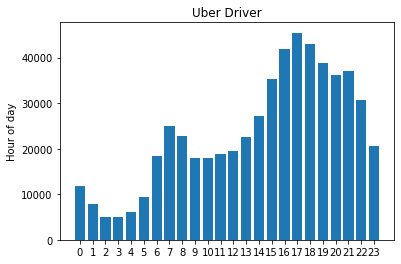

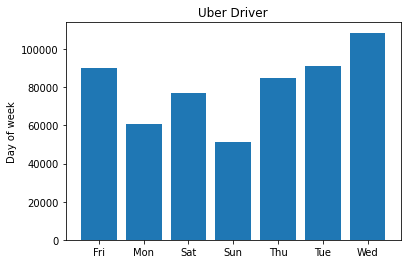

In [6]:
#load to pandas dataframe 
import matplotlib.pyplot as plt
import pandas as pd
#Get values from DF previous and plot them 
hour_pandasDF = hour_count.toPandas()
plt.bar(hour_pandasDF['hour'],hour_pandasDF['count'])
plt.title('Uber Driver')
plt.ylabel(f'Total hours driven')
plt.ylabel(f'Hour of day')
plt.xticks(hour_pandasDF['hour'])
plt.show()

#Plot weekdays 
weekday_pandasDF = weekday_count.toPandas()
plt.bar(weekday_pandasDF['weekday'],weekday_pandasDF['count'])
plt.title('Uber Driver')
plt.ylabel(f'Total hours driven')
plt.ylabel(f'Day of week')
plt.xticks(weekday_pandasDF['weekday'])
plt.show()




Text(0.5, 0, 'Hour')

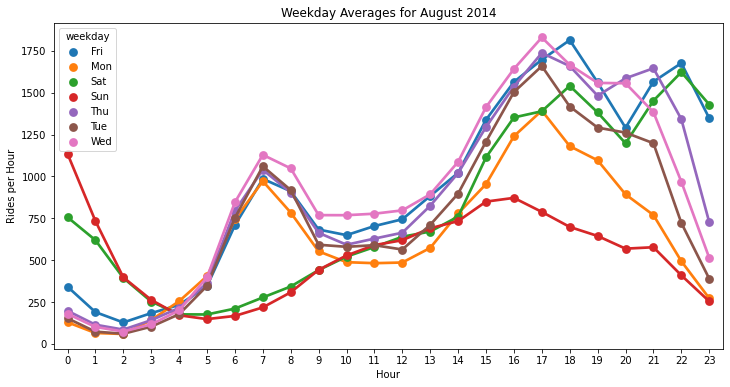

In [7]:
#Weekday hourly averages

wh_avg = hour_rides.groupBy('day','hour','weekday').count()
wh_avg_pandas = wh_avg.toPandas() #converting to pandas 


#Taking the average for a better plot  
wh_avg_pandas = wh_avg_pandas.groupby(['weekday','hour'])['count'].mean() #average of weekday,hour

wh_avg_pandas = wh_avg_pandas.reset_index()
wh_avg_pandas = wh_avg_pandas.rename(columns = {'count':'count_avg'})
wh_avg_pandas.head(20)

import seaborn as sns
## create figure
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)

sns.pointplot( x='hour',y='count_avg',hue='weekday', data = wh_avg_pandas)

## format plot labels
ax.set_title('Weekday Averages for August 2014');ax.set_ylabel('Rides per Hour');ax.set_xlabel('Hour')


In [8]:
#Geo plotting
geo_plot = df1.select(['Lat','Lon'])
geo_plot = geo_plot.select([F.col(c).cast('float') if c in ['Lat','Lon'] else c for c in geo_plot.columns]) #casts as float. 
geo_plot.show(3)
# collecting the max and min values of loat and lon. 
lat_max = geo_plot.agg({"Lat": "max"}).collect()[0][0]
lon_max = geo_plot.agg({"Lon": "max"}).collect()[0][0]
lat_min = geo_plot.agg({"Lat": "min"}).collect()[0][0]
lon_min = geo_plot.agg({"Lon": "min"}).collect()[0][0]
print(lat_max,lat_min,lon_max,lon_min)


+-------+--------+
|    Lat|     Lon|
+-------+--------+
| 40.769|-73.9549|
|40.7267|-74.0345|
|40.7316|-73.9873|
+-------+--------+
only showing top 3 rows

42.116600036621094 40.072898864746094 -72.06659698486328 -74.77330017089844


/home/ubuntu/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


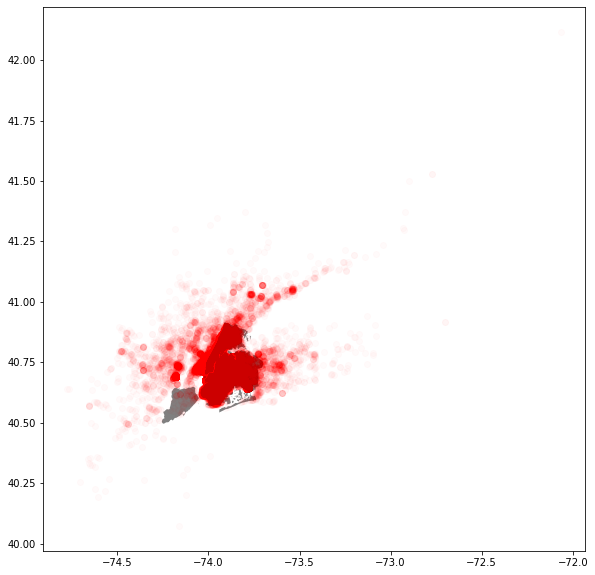

In [16]:

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt 
from shapely.geometry import Point, Polygon
dwr = gpd.read_file('/home/ubuntu/client/plot/geo_export.shp')
geo_df = geo_plot.toPandas()

# designate coordinate system
coordsys = {'init':'epsg:4326'}
# zip x and y coordinates into single feature
geom = [Point(xy) for xy in zip(geo_df['Lon'], geo_df['Lat'])]
# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(geo_df,crs = coordsys,geometry = geom)

#plot
fig,ax = plt.subplots(figsize=(10,10))
dwr.plot(ax=ax, color ='grey')
geo_df.plot(ax=ax,alpha=0.02,color='red')
plt.show()

In [ ]:
import pandas as pd
from folium import Map
from folium.plugins import HeatMap
for_map = Map(location=[lat_min, lon_max], zoom_start=8, )

hm_wide = HeatMap(geo_plot['Lat']['Lon']).add_to(for_map)

In [22]:
geo_plot.head(3)

[Row(Lat=40.76900100708008, Lon=-73.95490264892578),
 Row(Lat=40.72669982910156, Lon=-74.03450012207031),
 Row(Lat=40.73160171508789, Lon=-73.98729705810547)]

In [ ]:
import geopandas as gpd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,15))

dwr = gpd.read_file('/home/ubuntu/client/plot/geo_export.shp')
dwr.plot(ax=ax)

In [ ]:
# release the cores for another application!
spark_session.stop()